In [1]:
import ipywidgets as widgets
from IPython.display import display
from pitch_detect import *

# Create Start and Stop buttons
start_button = widgets.Button(description="Start")
stop_button = widgets.Button(description="Stop")

# Link button actions
start_button.on_click(start_detection)
stop_button.on_click(stop_detection)

# Display buttons
display(widgets.HBox([start_button, stop_button]))


Pitch detection started...
Pitch: 131.64 Hz, Note: C
Pitch: 130.09 Hz, Note: C
Pitch: 128.57 Hz, Note: C
Pitch: 128.20 Hz, Note: C
Pitch: 138.24 Hz, Note: C#
Pitch: 147.99 Hz, Note: D
Pitch: 156.94 Hz, Note: D#
Pitch: 166.42 Hz, Note: E
Pitch: 170.93 Hz, Note: F
Pitch: 170.93 Hz, Note: F
Pitch: 171.60 Hz, Note: F
Pitch: 170.93 Hz, Note: F
Pitch: 170.27 Hz, Note: F
Pitch: 153.66 Hz, Note: D#
Pitch: 160.95 Hz, Note: E
Pitch: 161.54 Hz, Note: E
Pitch: 161.54 Hz, Note: E
Pitch: 162.13 Hz, Note: E
Pitch: 162.13 Hz, Note: E
Pitch: 160.95 Hz, Note: E
Pitch: 163.33 Hz, Note: E
Pitch: 173.62 Hz, Note: F
Pitch: 175.00 Hz, Note: F
Pitch: 173.62 Hz, Note: F
Pitch: 172.94 Hz, Note: F
Pitch: 172.94 Hz, Note: F
Pitch: 172.27 Hz, Note: F
Pitch: 167.05 Hz, Note: E
Pitch: 172.27 Hz, Note: F
Pitch: 140.00 Hz, Note: C#
Pitch: 140.89 Hz, Note: C#
Pitch: 140.89 Hz, Note: C#
Pitch: 138.68 Hz, Note: C#
Pitch: 138.24 Hz, Note: C#
Pitch: 136.96 Hz, Note: C#
Pitch: 158.63 Hz, Note: D#
Pitch: 168.32 Hz, Note: E
P

TypeError: Argument `a` is not recognized as numeric. Support for input that cannot be coerced to a numeric array was deprecated in SciPy 1.9.0 and removed in SciPy 1.11.0. Please consider `np.unique`.

In [2]:
mode([i for i in pitches if i!=None]).mode

163.33333333333334

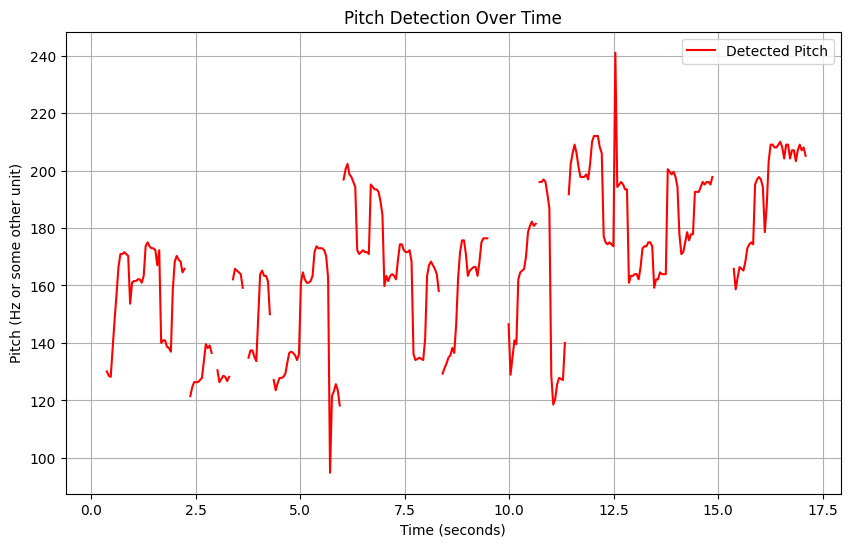

In [3]:

import matplotlib.pyplot as plt
time_points = [i*(BUF_SIZE/SAMPLE_RATE) for i in range(len(pitches))]  
notes = [note_from_pitch(i) if i!=None else None for i in pitches]

# Plot the notes over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, pitches, label="Detected Pitch", color='red')
plt.title("Pitch Detection Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz or some other unit)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for i in range(50,300,12):
    print(note_from_pitch(i))

In [ ]:
import pandas as pd
pitches = [i if i!=None else np.nan for i in pitches]

threshold = 7

df = pd.DataFrame({'time':time_points, 'pitches':pitches})
df['Diff'] = df['pitches'].diff()
df['BigJump'] = df['Diff'].apply(lambda x: np.abs(x)>threshold)
df['Split'] = df.apply(lambda x: pd.isnull(x['Diff']) or x['BigJump'], axis=1)

split_indices = df.index[df['Split']].tolist()

pitches_segments = np.split(df['pitches'].values, split_indices)
time_segments = np.split(df['time'].values, split_indices)

df

In [ ]:
# import numpy as np
# pitches = [i if i!=None else np.nan for i in pitches]
# pitch_diff = np.diff(pitches)
# threshold = 5
# jump_indices = np.where(np.abs(pitch_diff) > threshold)[0]

# segments = np.split(pitches, jump_indices + 1)
# segments = [np.array([np.nan]*len(a)) if len(a)<threshold else a for a in segments]
# time_segments = np.split(time_points[:len(pitches)], jump_indices + 1)

# Step 5: Plot the segments with different colors for each note
plt.figure(figsize=(10, 6))
colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange','red']

for i, segment in enumerate(pitches_segments):
    plt.plot(time_segments[i], segment, color=colors[i % len(colors)], label=f'Note {i+1}')

plt.title('Pitch Detection with Separated Notes')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch (Hz or some other unit)')
# plt.legend()
plt.grid(True)
plt.show()

# Print the separated segments for each note
for i, segment in enumerate(pitches_segments):
    if np.all(np.isnan(segment)): continue
    print(f"Note {i+1} (time {time_segments[i][0]:.2f}s to {time_segments[i][-1]:.2f}s): {segment}")
    mav = np.convolve(segment, np.ones(3)/3, mode='valid')
    print(np.nanstd(mav))

In [ ]:
time_points

In [ ]:
import numpy as np

# Define the thresholds
pitch_threshold = 5  # Pitch difference threshold for segmenting
time_gap_threshold = 0.5  # Maximum allowed time gap to consider them part of the same segment

# Clean pitch data, replacing None with np.nan
pitches_cleaned = [x if x is not None else np.nan for x in pitches]

# Calculate the pitch differences
pitch_diff = np.diff(pitches_cleaned)

# Detect pitch jumps based on the threshold
jump_indices = np.where(np.abs(pitch_diff) > pitch_threshold)[0]

# Split the pitches and time points based on detected jumps
segments = np.split(pitches, jump_indices + 1)
time_segments = np.split(time_points[:len(pitches)], jump_indices + 1)

# Now let's ensure that segments with large time gaps within them remain separate
final_segments = []
final_time_segments = []

for seg, time_seg in zip(segments, time_segments):
    if len(time_seg) > 1:
        # Find time gaps within each segment and check if they exceed the time_gap_threshold
        time_diff = np.diff(time_seg)
        gap_indices = np.where(time_diff > time_gap_threshold)[0]

        if len(gap_indices) > 0:
            # If there are time gaps within the segment, split further
            sub_segments = np.split(seg, gap_indices + 1)
            sub_time_segments = np.split(time_seg, gap_indices + 1)
            final_segments.extend(sub_segments)
            final_time_segments.extend(sub_time_segments)
        else:
            # If no significant time gap, keep the segment as is
            final_segments.append(seg)
            final_time_segments.append(time_seg)
    else:
        # Handle segments with only one point
        final_segments.append(seg)
        final_time_segments.append(time_seg)

# Plotting the final segments for visualization
import matplotlib.pyplot as plt

colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange','red']

plt.figure(figsize=(10, 6))
k = 0
for i, (seg, time_seg) in enumerate(zip(final_segments, final_time_segments)):
    k+=1
    plt.plot(time_seg, seg, color=colors[k% len(colors)], lw=2)

plt.title('Pitch Detection with Separated Notes')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch (Hz or some other unit)')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
pitch_diff = np.diff([x if x!=None else np.nan for x in pitches ])
threshold = 5
jump_indices = np.where(np.abs(pitch_diff) > threshold)[0]

notes = [i if i!=None else np.nan for i in notes]

segments = np.split(notes, jump_indices + 1)

segments = [np.array([None]*len(a)) if len(a)<threshold else np.array([np.nanmean(a)]*len(a)) for a in segments]
print(segments)
time_segments = np.split(time_points[:len(notes)], jump_indices + 1)

# Step 5: Plot the segments with different colors for each note
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']

for i, segment in enumerate(segments):
    plt.plot(time_segments[i], segment, color=colors[i % len(colors)], label=f'Note {i+1}')

plt.title('Pitch Detection with Separated Notes')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch (Hz or some other unit)')
# plt.legend()
plt.grid(True)
plt.show()

# Print the separated segments for each note
for i, segment in enumerate(segments):
    print(f"Note {i+1} (time {time_segments[i][0]:.2f}s to {time_segments[i][-1]:.2f}s): {segment}")

In [ ]:
# Plot the notes over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, pitches, label="Detected Pitch", color='red')
plt.title("Pitch Detection Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz or some other unit)")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
around = 3.2
buf = 10
pitch_dict = dict(zip(time_points, pitches))

req = {k:v for k,v in pitch_dict.items() if (k>(around-buf)) and (k<(around+buf))}

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(req.keys(), req.values(), label="Detected Pitch", color='red')
plt.title("Pitch Detection Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz or some other unit)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import sounddevice as sd
import soundfile as sf
import ipywidgets as widgets
from IPython.display import display, HTML
import time

# Add custom CSS to change the radio button text color
HTML('''
<style>
    .widget-radio { color: black; } /* Change to desired color */
    .widget-radio input { margin-right: 5px; }
</style>
''')

# Constants
SAMPLE_RATE = 44100  # Audio sample rate
BUF_SIZE = 2048      # Buffer size for processing
THRESHOLD = 0.01     # Threshold for RMS to filter low volume noise
OUTPUT_FILE = 'test_audio.wav' 
CHANNELS = 1

# Note names
NOTE_STRINGS = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
pitches = [] 

# Timer variable
last_pitch_time = None
detecting = True  # Flag to indicate if we are still detecting

def note_from_pitch(frequency):
    """Convert frequency to the nearest musical note."""
    note_num = 12 * (np.log2(frequency / 440.0))
    note_index = int(np.round(note_num)) + 69
    return NOTE_STRINGS[note_index % 12]

def detect_pitch(audio, sample_rate):
    """Autocorrelation method to estimate pitch."""
    audio = audio - np.mean(audio)  # Remove DC offset
    corr = np.correlate(audio, audio, mode='full')
    corr = corr[len(corr) // 2:]

    d = np.diff(corr)  # Finding the first peak in the autocorrelation
    start = np.where(d > 0)[0][0]  # The first positive slope

    peak = np.argmax(corr[start:]) + start
    if corr[peak] > THRESHOLD:
        T0 = peak
        return sample_rate / T0
    return -1

def process_audio_file(input_file):
    """Process the audio file to detect pitch."""
    audio_data, sample_rate = sf.read(input_file)
    audio_data = audio_data[:, 0]  # Use the first channel for mono input if stereo
    pitch = detect_pitch(audio_data, sample_rate)

    if pitch != -1 and pitch < 300:
        note = note_from_pitch(pitch)
        print(f"Detected Pitch from file: {pitch:.2f} Hz, Note: {note}")
    else:
        print("No pitch detected from file")

def audio_callback(indata, frames, time, status):
    """Process audio input in real-time."""
    global last_pitch_time, detecting
    if status:
        print(status)
    
    audio_file.write(indata)
    audio = indata[:, 0]  # Use the first channel for mono input
    volume_norm = np.linalg.norm(audio) * 10
    
    if volume_norm > THRESHOLD:
        pitch = detect_pitch(audio, SAMPLE_RATE)

        if pitch != -1 and pitch < 300:
            note = note_from_pitch(pitch)
            print(f"Detected Pitch from input: {pitch:.2f} Hz, Note: {note}")
            pitches.append(pitch)
            last_pitch_time = time.time()  # Reset timer when pitch is detected
        else:
            pitches.append(None)
    
    # Check for 7 seconds of silence (no pitch detected)
    if last_pitch_time is not None and (time.time() - last_pitch_time) > 7:
        detecting = False  # Stop detecting
        raise sd.CallbackStop  # Stop the stream

def start_real_time_detection():
    """Start real-time audio detection."""
    global audio_file, last_pitch_time, detecting
    audio_file = sf.SoundFile(OUTPUT_FILE, mode='w', samplerate=SAMPLE_RATE, channels=CHANNELS, subtype='PCM_16')
    
    last_pitch_time = time.time()  # Initialize timer
    detecting = True  # Reset detecting flag
    
    with sd.InputStream(callback=audio_callback, channels=1, samplerate=SAMPLE_RATE, blocksize=BUF_SIZE):
        print("Starting pitch detection...")
        while detecting:  # Keep running until detecting is set to False
            sd.sleep(100)  # Sleep briefly to avoid busy-waiting
    audio_file.close()
    print(f"Audio saved to {OUTPUT_FILE}")

# Create widgets
input_option = widgets.RadioButtons(
    options=['Real-time Detection', 'Audio File Detection'],
    description='Select Input Method:',
    disabled=False
)

file_input = widgets.Text(
    value='input_audio.wav',
    description='Input File:',
    disabled=False
)

button = widgets.Button(description="Start Detection")

def on_button_clicked(b):
    if input_option.value == 'Real-time Detection':
        start_real_time_detection()
    else:
        process_audio_file(file_input.value)

button.on_click(on_button_clicked)

# Display the widgets
display(input_option, file_input, button)
